In [1]:
from functools import reduce

from itertools import product

from datetime import datetime

import warnings

import pandas as pd

import numpy as np

import pickle

from tableone import TableOne

import sklearn
from sklearn import preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import ParameterGrid, cross_validate

from scipy.stats import ttest_rel

from pydtr.iqlearn.regression import IqLearnReg

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)

1.1.2
1.19.5
0.24.1


# Patient Characteristics (State)

In [4]:
# import baseline and followup data
data = pd.read_csv('data/baseline_followup.csv')
data['VISIT DATE'] = pd.to_datetime(data['VISIT DATE'])
data.head()

,id,VISIT,VISIT DATE,HbA1c,Gender,Age,Ethnicity,Diabetes treatment (diet),Diabetes treatment (oral therapy),Diabetes treatment (Insulin),...,DSCA_exercise,DSCA_glucose,DSCA_footcare,DSCA_smoking1,DSCA_smoking2,DSCA_additional diet,DSCA_additional medication,DSCA_additional footcare,BMI,Duration of diabetes
0,1001,0,2015-02-11,8.2,Female,55,Caucasian,1.0,1,1,...,5.0,7.0,0.5,0,0.0,2.0,7.0,4.666667,32.220833,15.112936
1,1002,0,2015-02-11,7.0,Male,53,Black,1.0,1,0,...,5.0,5.0,5.0,0,0.0,3.0,0.0,4.666667,38.008218,1.111567
2,1003,0,2015-03-05,8.7,Female,60,Caucasian,1.0,1,1,...,1.5,7.0,0.0,1,20.0,0.0,7.0,4.666667,37.096021,10.171116
3,1005,0,2015-03-05,7.9,Female,59,Caucasian,1.0,1,0,...,0.0,1.5,3.5,0,0.0,0.0,7.0,7.000000,38.588189,7.173169
4,1006,0,2015-03-18,9.7,Female,52,Caucasian,1.0,0,1,...,0.0,4.5,2.5,0,0.0,2.0,4.0,3.666667,21.254724,10.206708


In [5]:
# Numerical variables
covariate_num = [
    'BMI',
    'Duration of diabetes',
    'HbA1c',
    'Age',
    'Family physican visits',
    'Family physican visits related to diabetes',
    'EQ5D',
    'AddQoL',
    'DSCA_general diet',
    'DSCA_specific diet',
    'DSCA_exercise',
    'DSCA_glucose',
    'DSCA_footcare',
    'DSCA_smoking2',
    'DSCA_additional diet',
    'DSCA_additional medication',
    'DSCA_additional footcare'
]

# Categorical variables
covariate_cat = [
    'Gender',
    'Ethnicity',
    'Diabetes treatment (diet)',
    'Diabetes treatment (oral therapy)',
    'Diabetes treatment (Insulin)',
    'Diabetes treatment (Other)',
    'Stroke',
    'Transient Ischemc Attack',
    'Evidence of CAD',
    'Myocardial infarction',
    'Heart Failure',
    'Kidney Disease',
    'COPD',
    'Hyperlipidemia',
    'Hypertension',
    'Peripheral Arterial Disease',
    'Previous limb amputation',
    'Prescribed medications', 
    'Behavioral stage',
    'Chronic disease mgmt program',
    'Visits with health professional',
    'ER/hospital admissions',
    'DSCA_smoking1',
]

In [6]:
# Assess patient characteristics and generate Table 1
table1 = TableOne(data, columns = covariate_num+covariate_cat+['VISIT'], categorical = covariate_cat, groupby = 'VISIT', pval = True)
table1.to_csv('table1.csv')

# Outcome (Reward)

In [7]:
# Relative HbA1c reduction and EQ5D improvement
for i in set(data['id']):
    # HbA1c
    data.loc[(data['id']==i)&(data['VISIT']==1), 'HbA1c_reduction_rel'] = (data[(data['id']==i)&(data['VISIT']==0)]['HbA1c'].values-data[(data['id']==i)&(data['VISIT']==1)]['HbA1c'].values)/data[(data['id']==i)&(data['VISIT']==0)]['HbA1c'].values
    data.loc[(data['id']==i)&(data['VISIT']==2), 'HbA1c_reduction_rel'] = (data[(data['id']==i)&(data['VISIT']==0)]['HbA1c'].values-data[(data['id']==i)&(data['VISIT']==2)]['HbA1c'].values)/data[(data['id']==i)&(data['VISIT']==0)]['HbA1c'].values
    # EQ5D
    data.loc[(data['id']==i)&(data['VISIT']==1), 'EQ5D_improve_rel'] = (data[(data['id']==i)&(data['VISIT']==1)]['EQ5D'].values-data[(data['id']==i)&(data['VISIT']==0)]['EQ5D'].values)/data[(data['id']==i)&(data['VISIT']==0)]['EQ5D'].values
    data.loc[(data['id']==i)&(data['VISIT']==2), 'EQ5D_improve_rel'] = (data[(data['id']==i)&(data['VISIT']==2)]['EQ5D'].values-data[(data['id']==i)&(data['VISIT']==0)]['EQ5D'].values)/data[(data['id']==i)&(data['VISIT']==0)]['EQ5D'].values

In [8]:
# Derive the composite clinical outcome as relative HbA1c reduction and relative EQ5D improvement (normalized to [0,1], with a higher score being better)
scaler = preprocessing.MinMaxScaler()
data.loc[data['VISIT'].isin({1,2}), 'HbA1c_rel_scaled'] = scaler.fit_transform(data.loc[data['VISIT'].isin({1,2}), 'HbA1c_reduction_rel'].values.reshape(-1,1))
data.loc[data['VISIT'].isin({1,2}), 'EQ5D_rel_scaled'] = scaler.fit_transform(data.loc[data['VISIT'].isin({1,2}), 'EQ5D_improve_rel'].values.reshape(-1,1))

In [9]:
data[data['VISIT']==1][['id', 'HbA1c_reduction_rel', 'EQ5D_improve_rel', 'HbA1c_rel_scaled', 'EQ5D_rel_scaled']].head()

,id,HbA1c_reduction_rel,EQ5D_improve_rel,HbA1c_rel_scaled,EQ5D_rel_scaled
177,1001,0.036585,-0.043007,0.453419,0.153897
178,1002,0.028571,0.165282,0.445607,0.200528
179,1003,0.218391,0.146243,0.630637,0.196266
180,1005,0.101266,0.000000,0.516468,0.163525
181,1006,-0.082474,0.229712,0.337364,0.214953


In [10]:
data[data['VISIT']==2][['id', 'HbA1c_reduction_rel', 'EQ5D_improve_rel', 'HbA1c_rel_scaled', 'EQ5D_rel_scaled']].head()

,id,HbA1c_reduction_rel,EQ5D_improve_rel,HbA1c_rel_scaled,EQ5D_rel_scaled
354,1001,0.085366,0.049088,0.500969,0.174515
355,1002,0.014286,1.074552,0.431682,0.404094
356,1003,0.045977,-0.528197,0.462574,0.045274
357,1005,0.227848,-0.211514,0.639856,0.116172
358,1006,-0.206186,0.430992,0.216774,0.260015


# Coaching (Action)

In [11]:
# import coaching data
data_coaching = pd.read_csv('data/coaching.csv')
data_coaching['date of coaching'] = pd.to_datetime(data_coaching['date of coaching'])

In [12]:
# Group coaching recommendations into three big groups of treatments
## treatment BC+DE (behavior change and diabetes education): Dietary modification, Exercise modification, Behavioural modification
## treatment CM (case management): Medication adherence, Medication adjustment, Glucose monitoring, Case-management/monitoring, System navigation
## treament PS (psychosocial support): Psychosocial support and/or counselling
data_coaching['treatment_BC+DE'] = data_coaching[[
        'Dietary modification', 
        'Exercise modification', 
        'Behavioural modification']].sum(axis = 1)
data_coaching['treatment_CM'] = data_coaching[[
        'Medication adherence', 
        'Medication adjustment', 
        'Glucose monitoring', 
        'Case-management/monitoring', 
        'System navigation']].sum(axis = 1)
data_coaching['treatment_PS'] = data_coaching[[
        'Psychosocial support and/or counselling']].sum(axis = 1)

In [13]:
levels_recomm = [
    'Dietary modification',
    'Exercise modification',
    'Behavioural modification',
    'Medication adherence',
    'Medication adjustment',
    'Glucose monitoring',
    'Psychosocial support and/or counselling',
    'Case-management/monitoring',
    'System navigation'
    ]

levels_trt = [
    'treatment_BC+DE', 
    'treatment_CM', 
    'treatment_PS'
]

In [14]:
# Map date of coaching with stages
## Stage 1: baseline to 6m follow-up visit
## Stage 2: 6m follow-up visit to 12m follow-up visit
for id in set(data['id']):

    # extract visit dates for baseline, 6m and 12m visits
    date_bl = data[(data['id']==id)&(data['VISIT']==0)]['VISIT DATE'].values[0]
    date_6m = data[(data['id']==id)&(data['VISIT']==1)]['VISIT DATE'].values[0]
    date_12m = data[(data['id']==id)&(data['VISIT']==2)]['VISIT DATE'].values[0]
    
    # Stage 1: baseline to 6m follow-up visit
    # Stage 2: 6m follow-up visit to 12m follow-up visit
    data_coaching.loc[(data_coaching['id']==id)&(data_coaching['date of coaching']>=date_bl)&(data_coaching['date of coaching']<date_6m), 'interval'] = 1
    data_coaching.loc[(data_coaching['id']==id)&(data_coaching['date of coaching']>=date_6m)&(data_coaching['date of coaching']<=date_12m), 'interval'] = 2
    data_coaching['interval'].fillna('out of bound', inplace = True)

print(data_coaching[['interval']].value_counts())

# Remove coaching data if the date of coaching is out of bound (i.e., not in stage 1 or stage 2)
data_coaching = data_coaching[data_coaching['interval']!='out of bound']

interval    
1               1940
2               1039
out of bound     145
dtype: int64


In [15]:
# Feature engineering on coaching data
def coaching_fe(data, levels_recomm, levels_trt, interval):
    
    '''Compute the overall and relative intensity of each coaching recommendation and treatment.

    Parameters:
        data: DataFrame
            A data frame with contains the raw coaching information.
            Each row represents an interaction between the patient and the coach, where one or multiple coaching recommendations were made.
        levels_recomm: list
            A list containing all nine distinct values of coaching recommendations.
        levels_trt: list
            A list containing all three distinct values of treatment.
        interval: integer
            An integer value indicating the stage of coaching.
            interval = 1: baseline to 6m follow-up
            interval = 2: 6m to 12m follow-up
            
    Returns:
        coaching: DataFrame
            A data frame containing the information regarding the overall and relative intensity of each coaching recommendation and treatment.
    '''

    # Overall intensity: total # of coaching recommendation
    recomm_count = pd.DataFrame(data[levels_recomm+['id']].groupby('id').agg('sum')[levels_recomm].sum(axis=1))
    recomm_count.rename(columns = {recomm_count.columns[0]: 'recomm_count'}, inplace = True)
    
    # Relative intensity: proportion of each coaching recommendation
    data[levels_recomm] = data[levels_recomm].fillna(0)
    recomm = data[levels_recomm+['id']].groupby('id').agg('sum')
    recomm = recomm.merge(recomm_count, on = 'id')
    for col in levels_recomm:
        recomm[col] = recomm[col]/recomm['recomm_count']
        
    # Overall intensity: total # of treatment
    trt_count = pd.DataFrame(data[levels_trt+['id']].groupby('id').agg('sum')[levels_trt].sum(axis=1))
    trt_count.rename(columns = {trt_count.columns[0]: 'trt_count'}, inplace = True)

    # Relative intensity: proportion of each treatment
    data[levels_trt] = data[levels_trt].fillna(0)
    trt = data[levels_trt+['id']].groupby('id').agg('sum')
    trt = trt.merge(trt_count, on = 'id')
    for col in levels_trt:
        trt[col] = trt[col]/trt['trt_count']

    # Join recommendation and treatment
    coaching = reduce(lambda x, y: x.merge(y, on='id'), [recomm.fillna(0), trt.fillna(0)])
    coaching['interval'] = interval
    
    return coaching

In [16]:
# Feature engineering on coaching data
data_coaching_s1 = coaching_fe(data_coaching[data_coaching['interval']==1], levels_recomm, levels_trt, interval=1)
data_coaching_s2 = coaching_fe(data_coaching[data_coaching['interval']==2], levels_recomm, levels_trt, interval=2)
coaching = pd.concat([data_coaching_s1, data_coaching_s2], axis = 0)

# Join patient characteristics (state) with coaching data (action)
data = data.merge(coaching, left_on = ['id', 'VISIT'], right_on = ['id', 'interval'], how = 'left')

# Fill missing values with 0
data = data.fillna(0)

In [17]:
# Create the action space

## Intensity:
avg_intensity = np.median(data[data['VISIT'].isin([1, 2])]['trt_count'])
data['intensity'] = np.where(data['trt_count'] > avg_intensity, 'high', 'low')

# Focus: coaching delivered in a stage can be classified as focused on one of the three treatments if a patient have at least twice as many treatments in one category compared to the others – otherwise they were classified as general coaching.
data['focus'] = np.where(data['treatment_BC+DE']/data['treatment_CM']>2, 'treatment_BC+DE',
                         np.where(data['treatment_CM']/data['treatment_BC+DE']>2, 'treatment_CM', 'treatment_mix'))

# Define an action using two dimensions: intensity and focus
data['treatment'] = data['intensity']+'_'+data['focus']

# Model Development and Validation

In [18]:
# Specify the action variable
data = data.rename(columns = {'treatment':'action'})

In [19]:
# Compute the composite clinical outcome variable as 0.5*relative reduction in HbA1c + 0.5**relative improvement in EQ5D
HbA1c_weight = 0.5
data['outcome'] = HbA1c_weight * data['HbA1c_rel_scaled'] + (1-HbA1c_weight) * data['EQ5D_rel_scaled']

In [20]:
# Encode the action space
action_dict = {
    'low_treatment_BC+DE': 0, 'low_treatment_CM': 1, 'low_treatment_mix': 2,
    'high_treatment_BC+DE': 3, 'high_treatment_CM': 4, 'high_treatment_mix': 5
}

action_dict_inverse = {
    0: 'treatment_BC+DE', 1: 'treatment_CM', 2: 'treatment_mix',
    3: 'high intensity treatment_BC+DE', 4: 'high intensity treatment_CM', 5: 'high intensity treatment_mix'
}

data['action'] = data['action'].replace(action_dict)

In [21]:
# Order-encoding the categorical variables
enc = preprocessing.OrdinalEncoder()
data[covariate_cat+['action']] = enc.fit_transform(data[covariate_cat+['action']])

In [22]:
# Data preparation for the dynamic treatment regime model
predictors = covariate_num+covariate_cat

# State
X = data[data['VISIT'].isin([0, 1])][['id', 'VISIT'] + predictors]
X1 = X[X['VISIT']==0].drop(columns = ['VISIT'])
X2 = X[X['VISIT']==1].drop(columns = ['VISIT'])

# Reward
y1 = data[data['VISIT']==1][['outcome', 'id']]
y2 = data[data['VISIT']==2][['outcome', 'id']]

# Action
A1 = data[data['VISIT']==1][['action', 'id']]
A2 = data[data['VISIT']==2][['action', 'id']]

df1 = reduce(lambda x,y: pd.merge(x, y, on = 'id'), [X1, A1, y1]); df1.columns = df1.columns+'_1'
df2 = reduce(lambda x,y: pd.merge(x, y, on = 'id'), [X2, A2, y2]); df2.columns = df2.columns+'_2'
df = pd.merge(df1, df2, left_on = 'id_1', right_on = 'id_2').drop(columns = ['id_1', 'id_2'])

cols = df.columns.to_list()

cat_idx_stage1 = [df.columns.get_loc(c) for c in [col+'_1' for col in covariate_cat+['action']] if c in df]
cat_idx_stage2 = [df.columns.get_loc(c) for c in [col+'_1' for col in covariate_cat+['action']]+[col+'_2' for col in covariate_cat+['action']] if c in df]

In [23]:
# Model development

# specify hyper-parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5], 
    'max_iter': [50, 100, 200, 1000], 
    'max_depth': [5, 10, None],
    'l2_regularization': [0.1, 0.5, 1]
}

params = [dict(zip(param_grid.keys(), value)) for value in product(*param_grid.values())]

# For loop for hyperpamameter tuning
outcomes_stage2 = []

for param in params:
    
    param1 = param.copy(); param1.update({'categorical_features': cat_idx_stage1})
    param2 = param.copy(); param2.update({'categorical_features': cat_idx_stage2})

    model_info = [
        {
            "model": HistGradientBoostingRegressor(**param1),
            "action_dict": {"action_1": [0, 1, 2, 3, 4, 5]},
            "feature": df1.drop(columns = ["id_1", "outcome_1"]).columns.to_list(),
            "outcome": "outcome_1",
            "importance": False
        },
        {
            "model": HistGradientBoostingRegressor(**param2),
            "action_dict": {"action_2": [0, 1, 2, 3, 4, 5]},
            "feature": df.drop(columns = ["outcome_2"]).columns.to_list(),
            "outcome": "outcome_2",
            "importance": False
        }
    ]

    # Fit model
    dtr_model = IqLearnReg(n_stages = 2, model_info = model_info)
    dtr_model.fit(df)
    
    # Compute the predicted end-of-stage 2 outcome
    res_stage2 =  dtr_model.predict(df, 1).rename(columns = {'val': 'val2'})
    outcomes_stage2.append(res_stage2['val2'].mean())

Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
Stage: 0
Stage: 1
S

In [24]:
# Select the hyperparameters associated the best predicted end-of-stage 2 outcome
param_selected = params[np.argmax(outcomes_stage2)]

param1 = param_selected.copy(); param1.update({'categorical_features': cat_idx_stage1})
param2 = param_selected.copy(); param2.update({'categorical_features': cat_idx_stage2})

model_info = [
    {
        "model": HistGradientBoostingRegressor(**param1),
        "action_dict": {"action_1": [0, 1, 2, 3, 4, 5]},
        "feature": df1.drop(columns = ["id_1", "outcome_1"]).columns.to_list(),
        "outcome": "outcome_1",
        "importance": False
    },
    {
        "model": HistGradientBoostingRegressor(**param2),
        "action_dict": {"action_2": [0, 1, 2, 3, 4, 5]},
        "feature": df.drop(columns = ["outcome_2"]).columns.to_list(),
        "outcome": "outcome_2",
        "importance": False
    }
]

# Save the stage 1 model
pickle.dump(dtr_model.model_all[0], open('model/model_stage1', 'wb'))

# Save the stage 2 model
pickle.dump(dtr_model.model_all[1], open('model/model_stage2', 'wb'))

In [25]:
# Summarize the results

## Stage 1
res_stage1 = dtr_model.predict(df, 0).rename(columns = {'val': 'val1'})
## Stage 2
res_stage2 = dtr_model.predict(df, 1).rename(columns = {'val': 'val2'})
## Combine the results from stages 1 and 2
res = res_stage1.merge(res_stage2, how = 'inner', left_index = True, right_index = True)

# Calcualte the model's objective function value
res['objective_function'] = res['val1']
print('Model estimated (discounted) sum of reward:', res['objective_function'].mean(), sep = '')

Model estimated (discounted) sum of reward:0.8111401549920926


In [26]:
# Summarize the observed results

## Stage 1
y1 = y1.rename(columns = {'outcome': 'outcome1'})
## Stage 2
y2 = y2.rename(columns = {'outcome': 'outcome2'})
## Combine the observed results from stages 1 and 2
res_obs = y1.merge(y2, how = 'inner', left_on = 'id', right_on = 'id')

# Calcualte the observed objective function value
res_obs['objective_function'] = res_obs['outcome1'] + res_obs['outcome2']
print('Observed (discounted) sum of reward:', res_obs['objective_function'].mean())

Observed (discounted) sum of reward: 0.7666198649210056


In [27]:
# Test for statistical significance (paired t test)
print(ttest_rel(res['objective_function'], res_obs['objective_function']))

Ttest_relResult(statistic=10.04041103160829, pvalue=4.862769670876237e-19)


In [28]:
# Compute the clinical agreement between the diabetes coach and the model
res_1 = pd.concat([res_stage1, A1[['action']].reset_index(drop=True)], axis = 1)
res_1 = res_1.merge(df[['outcome_1']].reset_index(), on = res_1.index)
res_2 = pd.concat([res_stage2, A2[['action']].reset_index(drop=True)], axis = 1)
res_2 = res_2.merge(df[['outcome_2']].reset_index(), on = res_2.index)
agree_stage_1 = res_1[res_1['action_1']==res_1['action']]
agree_stage_2 = res_2[res_2['action_2']==res_2['action']]
print('Stage 1 proportion of agreement between DTR model and the coach:', agree_stage_1.shape[0]/res_1.shape[0])
print('Stage 2 proportion of agreement between DTR model and the coach:', agree_stage_2.shape[0]/res_2.shape[0])

Stage 1 proportion of agreement between DTR model and the coach: 0.1751412429378531
Stage 2 proportion of agreement between DTR model and the coach: 0.14124293785310735


0.8396954459889457
0.791162548569098
0.754664498252315


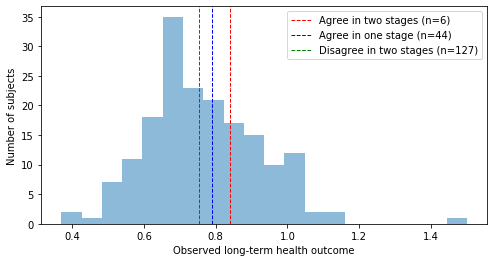

In [29]:
# Result visualization

# Observed outcome of patients where diabetes coach agreed with the model in two stages
agree_two_stages = list(set(agree_stage_1.index.to_list()).intersection(agree_stage_2.index.to_list()))
outcome_agree2 = df[df.index.isin(agree_two_stages)]['outcome_1']+df[df.index.isin(agree_two_stages)]['outcome_2']
print(outcome_agree2.mean())

# Observed outcome of patients where diabetes coach agreed with the model in either stage (stage 1 or 2, but not both stages)
agree_either_stage = np.setdiff1d(list(set(agree_stage_1.index.to_list() + agree_stage_2.index.to_list())), agree_two_stages)
outcome_agree1 = df[df.index.isin(agree_either_stage)]['outcome_1']+df[df.index.isin(agree_either_stage)]['outcome_2']
print(outcome_agree1.mean())

# Observed outcome of patients where diabetes coach did NOT agree with the model in two stages
disagree = np.setdiff1d(np.setdiff1d(df.index, agree_either_stage), agree_two_stages)
outcome_disagree = df[df.index.isin(disagree)]['outcome_1']+df[df.index.isin(disagree)]['outcome_2']
print(outcome_disagree.mean())

# histogram 
x = df['outcome_1']+df['outcome_2']
plt.figure(figsize=(8, 4))
plt.hist(x, bins = 20, alpha = 0.5)
plt.axvline(outcome_agree2.mean(), color='red', linestyle='dashed', linewidth=1, label='Agree in two stages (n=6)')
plt.axvline(outcome_agree1.mean(), color='blue', linestyle='dashed', linewidth=1, label='Agree in one stage (n=44)')
plt.axvline(outcome_disagree.mean(), color='green', linestyle='dashed', linewidth=1, label='Disagree in two stages (n=127)')
plt.xlabel("Observed long-term health outcome")
plt.ylabel("Number of subjects")
plt.legend(loc='upper right')